In [1]:
# Importaciones para primera parte
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

#Importaciones para segunda parte
from datapackage import Package

# Analisis de COVID-19

## Concepto e idea
Este Notebook tiene como fin mostar paso a paso, con explciaciones y comentarios, los distintos planteamientos de los datos de este proyecto.

La idea central es ir tomando datos epidemiológicos (y otros de soporte) de diferentes fuentes, proceasarlos, analizarlos desde diferentes enfoques e ir profundizando en nuevas herramientas.

## Primera Parte
### Objetivo
Obtener datos epidemiológicos de COVID-19 (Nuevos Casos y NUevas Muertes) y construir graficos comparativos entre países.
### Fuentes de Datos
* Dataset (en formato CSV) utilizada en el Dashboard de la OMS (https://covid19.who.int/WHO-COVID-19-global-data.csv)

In [2]:
# Extracción de CSV de sitio de la onu
data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', 
                   parse_dates=['Date_reported'])

In [3]:
data.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-24,AF,Afghanistan,EMRO,5,5,0,0
1,2020-02-25,AF,Afghanistan,EMRO,0,5,0,0
2,2020-02-26,AF,Afghanistan,EMRO,0,5,0,0
3,2020-02-27,AF,Afghanistan,EMRO,0,5,0,0
4,2020-02-28,AF,Afghanistan,EMRO,0,5,0,0


In [4]:
# Trim de etiquetas de columna ... issue del CSV de origen.
dic={}
for col in data.columns.values.tolist():
    dic[col]=col.strip()
data.rename(columns=dic, inplace=True)
data = data[['Date_reported', 
             'Country_code', 
             'Country', 
             'New_cases', 
             'New_deaths']]

In [5]:
data.head()

,Date_reported,Country_code,Country,New_cases,New_deaths
0,2020-02-24,AF,Afghanistan,5,0
1,2020-02-25,AF,Afghanistan,0,0
2,2020-02-26,AF,Afghanistan,0,0
3,2020-02-27,AF,Afghanistan,0,0
4,2020-02-28,AF,Afghanistan,0,0


In [6]:
# Agrupar paises y definir la fecha del día epidemiológico uno
data_country = data[['Country','Country_code','Date_reported']].groupby(['Country','Country_code']).min()
data_country.reset_index(inplace=True)
data_country.rename(columns={'Date_reported':'Date_one'}, inplace=True)

In [7]:
data_country.head()

,Country,Country_code,Date_one
0,Afghanistan,AF,2020-02-24
1,Albania,AL,2020-03-09
2,Algeria,DZ,2020-02-25
3,Andorra,AD,2020-03-03
4,Angola,AO,2020-03-21


In [8]:
# Crea calendario basico en base a las fechas minima y maxima de la data completa, que incluye 
# dia epidemiológico y de pandemia.

cal_start = data['Date_reported'].min()
cal_end = data['Date_reported'].max()

l_date=[]
l_n=[]
l_country=[]
l_country_code=[]
l_n_ep=[]
for i in range(0, data_country.shape[0]):
    n=0
    d=cal_start
    while d < cal_end:
        d=cal_start + dt.timedelta(days=n)
        n+=1
        l_country.append(data_country['Country'].tolist()[i])
        l_country_code.append(data_country['Country_code'].tolist()[i])
        l_date.append(d)
        l_n.append(n)
        diff = d - data_country['Date_one'].tolist()[i]
        diff = diff.days+1
        if diff<1:
            diff=0
        l_n_ep.append(diff)
        
calendar=pd.DataFrame({'Country':l_country, 
                       'Country_code':l_country_code, 
                       'Date':l_date, 
                       'Pandemic_day':l_n, 
                       'Epidemic_day':l_n_ep})

In [9]:
calendar.head()

,Country,Country_code,Date,Pandemic_day,Epidemic_day
0,Afghanistan,AF,2020-01-04,1,0
1,Afghanistan,AF,2020-01-05,2,0
2,Afghanistan,AF,2020-01-06,3,0
3,Afghanistan,AF,2020-01-07,4,0
4,Afghanistan,AF,2020-01-08,5,0


In [10]:
# Hace la unión entre los datos y el calendarí que creamos
data.drop('Country_code', axis=1, inplace=True)
data_final = calendar.merge(data, how='left', left_on=['Country','Date'], right_on=['Country','Date_reported'])
data_final.drop('Date_reported', axis=1, inplace=True)
data_final['New_deaths'].fillna(0,inplace=True)
data_final['New_cases'].fillna(0,inplace=True)

In [11]:
data_final.head()

,Country,Country_code,Date,Pandemic_day,Epidemic_day,New_cases,New_deaths
0,Afghanistan,AF,2020-01-04,1,0,0.0,0.0
1,Afghanistan,AF,2020-01-05,2,0,0.0,0.0
2,Afghanistan,AF,2020-01-06,3,0,0.0,0.0
3,Afghanistan,AF,2020-01-07,4,0,0.0,0.0
4,Afghanistan,AF,2020-01-08,5,0,0.0,0.0


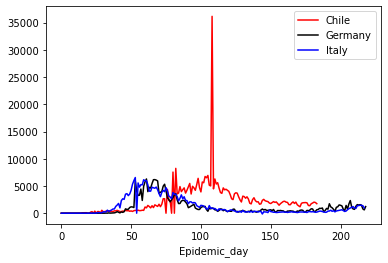

In [12]:
# Mostramos un grafico
ax=plt.gca()
dic_ctry = {'Chile':'red',
            'Germany':'black',
            'Italy':'blue'}
for e in dic_ctry:
    data_final[(data_final['Country']==e)].plot(kind='line', label=e, x='Epidemic_day',y='New_cases',ax=ax, color=dic_ctry[e])
plt.show()

## Segunda Parte
### Objetivo
Obtener datos epidemiológicos de COVID-19 (Nuevos Casos y Nuevas Muertes) y construir graficos comparativos entre países.

En esta ocación haremos un ejercicio de suavización de curva y la inclusión de datos de país de una fuente externa
### Fuentes de Datos
* Dataset (en formato CSV) utilizada en el Dashboard de la OMS (https://covid19.who.int/WHO-COVID-19-global-data.csv)
* Dataset (formato CVS) originado de un Paquete Json que contiene datos de paises (https://datahub.io/core/country-codes/datapackage.json)

In [156]:
# Extracción del paquete y posterior CSV con información de países.
package = Package('https://datahub.io/core/country-codes/datapackage.json')
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        ctry_data = pd.read_csv(resource.descriptor['path'])

In [157]:
ctry_data.head()

,official_name_ar,official_name_cn,official_name_en,official_name_es,official_name_fr,official_name_ru,ISO3166-1-Alpha-2,ISO3166-1-Alpha-3,ISO3166-1-numeric,ISO4217-currency_alphabetic_code,...,Least Developed Countries (LDC),MARC,Region Code,Region Name,Small Island Developing States (SIDS),Sub-region Code,Sub-region Name,TLD,WMO,is_independent
0,NaN,NaN,NaN,NaN,NaN,NaN,TW,TWN,158.0,NaN,...,NaN,ch,NaN,NaN,NaN,NaN,NaN,.tw,NaN,Yes
1,أفغانستان,阿富汗,Afghanistan,Afganistán,Afghanistan,Афганистан,AF,AFG,4.0,AFN,...,x,af,142.0,Asia,NaN,34.0,Southern Asia,.af,AF,Yes
2,ألبانيا,阿尔巴尼亚,Albania,Albania,Albanie,Албания,AL,ALB,8.0,ALL,...,NaN,aa,150.0,Europe,NaN,39.0,Southern Europe,.al,AB,Yes
3,الجزائر,阿尔及利亚,Algeria,Argelia,Algérie,Алжир,DZ,DZA,12.0,DZD,...,NaN,ae,2.0,Africa,NaN,15.0,Northern Africa,.dz,AL,Yes
4,ساموا الأمريكية,美属萨摩亚,American Samoa,Samoa Americana,Samoa américaines,Американское Самоа,AS,ASM,16.0,USD,...,NaN,as,9.0,Oceania,x,61.0,Polynesia,.as,NaN,Territory of US


In [158]:
# Definición de campos que efectivamente utilizaremos
ctry_data = ctry_data[['official_name_en', 
                       'official_name_es', 
                       'ISO3166-1-Alpha-2',
                       'ISO3166-1-Alpha-3',
                       'CLDR display name',
                       'Continent',
                       'Region Name', 
                       'Sub-region Name']]

In [159]:
ctry_data.head()

,official_name_en,official_name_es,ISO3166-1-Alpha-2,ISO3166-1-Alpha-3,CLDR display name,Continent,Region Name,Sub-region Name
0,NaN,NaN,TW,TWN,Taiwan,AS,NaN,NaN
1,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia
2,Albania,Albania,AL,ALB,Albania,EU,Europe,Southern Europe
3,Algeria,Argelia,DZ,DZA,Algeria,AF,Africa,Northern Africa
4,American Samoa,Samoa Americana,AS,ASM,American Samoa,OC,Oceania,Polynesia


In [160]:
# Corrección especifica de información faltante para Taiwan y Antartica, y agregar Otros (opcional)
ctry_data[(ctry_data['ISO3166-1-Alpha-2']=='TW')] = ctry_data[(ctry_data['ISO3166-1-Alpha-2']=='TW')].fillna({'official_name_en':'Taiwan', 'official_name_es':'Taiwan', 'Region Name':'Asia', 'Sub-region Name':'Eastern Asia'})
ctry_data[(ctry_data['ISO3166-1-Alpha-2']=='AQ')] = ctry_data[(ctry_data['ISO3166-1-Alpha-2']=='AQ')].fillna('Antarctica')
ctry_data = ctry_data.append({'official_name_en':'Other',
                              'official_name_es':'Otro',
                              'ISO3166-1-Alpha-2':'OO',
                              'ISO3166-1-Alpha-3':'OOO',
                              'CLDR display name':'Other',
                              'Continent':'OO',
                              'Region Name':'Other',
                              'Sub-region Name':'Other'},
                             ignore_index=True)

In [161]:
ctry_data.head()

,official_name_en,official_name_es,ISO3166-1-Alpha-2,ISO3166-1-Alpha-3,CLDR display name,Continent,Region Name,Sub-region Name
0,Taiwan,Taiwan,TW,TWN,Taiwan,AS,Asia,Eastern Asia
1,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia
2,Albania,Albania,AL,ALB,Albania,EU,Europe,Southern Europe
3,Algeria,Argelia,DZ,DZA,Algeria,AF,Africa,Northern Africa
4,American Samoa,Samoa Americana,AS,ASM,American Samoa,OC,Oceania,Polynesia


In [162]:
#Extracción de CSV de sitio de la onu (Igual que en la primera parte)
data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv', 
                   parse_dates=['Date_reported'])

In [163]:
data.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-02-24,AF,Afghanistan,EMRO,5,5,0,0
1,2020-02-25,AF,Afghanistan,EMRO,0,5,0,0
2,2020-02-26,AF,Afghanistan,EMRO,0,5,0,0
3,2020-02-27,AF,Afghanistan,EMRO,0,5,0,0
4,2020-02-28,AF,Afghanistan,EMRO,0,5,0,0


In [164]:
# Trim de etiquetas de columna ... issue del CSV de origen.
dic={}
for col in data.columns.values.tolist():
    dic[col]=col.strip()
data.rename(columns=dic, inplace=True)
data = data[['Date_reported',
             'Country_code', 
             'New_cases', 
             'New_deaths']]

In [165]:
data.head()

,Date_reported,Country_code,New_cases,New_deaths
0,2020-02-24,AF,5,0
1,2020-02-25,AF,0,0
2,2020-02-26,AF,0,0
3,2020-02-27,AF,0,0
4,2020-02-28,AF,0,0


In [166]:
# Alinea los periodos entre fechas a un día (opcional)
data_g=data.groupby('Country_code').apply(lambda x: x.set_index('Date_reported').resample('1D').first())

In [167]:
data_g.head()

Country_code  New_cases  New_deaths
Country_code Date_reported                                    
             2020-02-05                         14           0
             2020-02-06                         10           0
             2020-02-07                         41           0
             2020-02-08                          3           0
             2020-02-09                          6           0

In [168]:
# Calcula valores medios en el periodo definido
data_f = data_g.groupby(level=0)[['New_cases','New_deaths']].apply(lambda x: x.rolling(window=14, min_periods=1).mean()).reset_index()

In [169]:
# Corrige el country code de Others
data_f['Country_code'].replace([' '],'OO',inplace=True)
data['Country_code'].replace([' '],'OO',inplace=True)

In [170]:
data_f

,Country_code,Date_reported,New_cases,New_deaths
0,OO,2020-02-05,14.000000,0.000000
1,OO,2020-02-06,12.000000,0.000000
2,OO,2020-02-07,21.666667,0.000000
3,OO,2020-02-08,17.000000,0.000000
4,OO,2020-02-09,14.800000,0.000000
...,...,...,...,...
38608,ZW,2020-08-28,93.000000,4.357143
38609,ZW,2020-08-29,94.000000,4.785714
38610,ZW,2020-08-30,87.857143,4.714286
38611,ZW,2020-08-31,82.214286,4.571429


In [171]:
# Unir tabla de datos diarios con tabla suavizada.
data = data.merge(data_f,how='left',on=['Country_code','Date_reported'],suffixes=('','_s'))

In [172]:
data[:10]

,Date_reported,Country_code,New_cases,New_deaths,New_cases_s,New_deaths_s
0,2020-02-24,AF,5,0,5.000000,0.0
1,2020-02-25,AF,0,0,2.500000,0.0
2,2020-02-26,AF,0,0,1.666667,0.0
3,2020-02-27,AF,0,0,1.250000,0.0
4,2020-02-28,AF,0,0,1.000000,0.0
5,2020-02-29,AF,0,0,0.833333,0.0
6,2020-03-01,AF,0,0,0.714286,0.0
7,2020-03-02,AF,0,0,0.625000,0.0
8,2020-03-03,AF,0,0,0.555556,0.0
9,2020-03-04,AF,0,0,0.500000,0.0


In [173]:
# Eliminar NaN en caso de que existan (opcional)
data.dropna(inplace=True)

In [174]:
# Definir día epidémico y pandémico
data_ep = data[['Country_code','Date_reported']].groupby('Country_code').min().reset_index()
data = data.merge(data_ep,how='left',on='Country_code',suffixes=('','_a'))
data['Date_reported_b']=data['Date_reported'].min()
data['Epidemic_day']=(data['Date_reported']-data['Date_reported_a']).dt.days + 1
data['Pandemic_day']=(data['Date_reported']-data['Date_reported_b']).dt.days + 1
data.drop(['Date_reported_a','Date_reported_b'],axis=1,inplace=True)

In [175]:
data

,Date_reported,Country_code,New_cases,New_deaths,New_cases_s,New_deaths_s,Epidemic_day,Pandemic_day
0,2020-02-24,AF,5,0,5.000000,0.000000,1,52
1,2020-02-25,AF,0,0,2.500000,0.000000,2,53
2,2020-02-26,AF,0,0,1.666667,0.000000,3,54
3,2020-02-27,AF,0,0,1.250000,0.000000,4,55
4,2020-02-28,AF,0,0,1.000000,0.000000,5,56
...,...,...,...,...,...,...,...,...
38608,2020-08-28,ZW,41,10,93.000000,4.357143,162,238
38609,2020-08-29,ZW,96,6,94.000000,4.785714,163,239
38610,2020-08-30,ZW,18,1,87.857143,4.714286,164,240
38611,2020-08-31,ZW,6,0,82.214286,4.571429,165,241


In [176]:
# Agregar información de País
data = data.merge(ctry_data, how='left',left_on='Country_code',right_on='ISO3166-1-Alpha-2')

In [220]:
data.head()

,Date_reported,Country_code,New_cases,New_deaths,New_cases_s,New_deaths_s,Epidemic_day,Pandemic_day,official_name_en,official_name_es,ISO3166-1-Alpha-2,ISO3166-1-Alpha-3,CLDR display name,Continent,Region Name,Sub-region Name
0,2020-02-24,AF,5,0,5.000000,0.0,1,52,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia
1,2020-02-25,AF,0,0,2.500000,0.0,2,53,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia
2,2020-02-26,AF,0,0,1.666667,0.0,3,54,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia
3,2020-02-27,AF,0,0,1.250000,0.0,4,55,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia
4,2020-02-28,AF,0,0,1.000000,0.0,5,56,Afghanistan,Afganistán,AF,AFG,Afghanistan,AS,Asia,Southern Asia


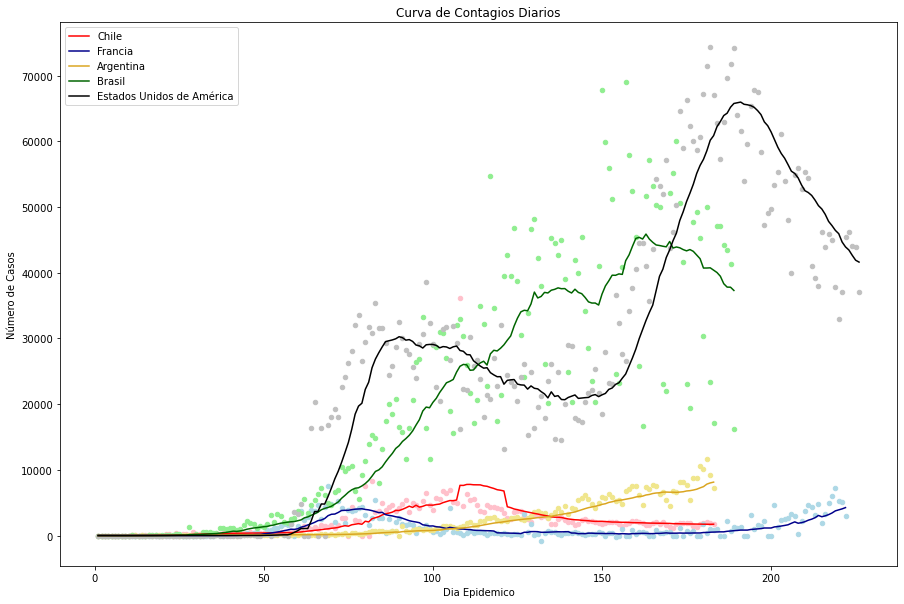

In [246]:
%matplotlib inline
ctry = {'CL':['red','pink'], 
        'FR':['darkblue','lightblue'],
        'AR':['goldenrod','khaki'],
        'BR':['darkgreen','lightgreen'],
        'US':['black','silver']}
ax=plt.gca()
for x in ctry:
    ctry_name = ctry_data.loc[ctry_data['ISO3166-1-Alpha-2']==x,'official_name_es'].values[0]
    data[(data['Country_code']==x)].plot(figsize=(15,10),kind='line', label=ctry_name, x='Epidemic_day',y='New_cases_s',ax=ax, color=ctry[x][0])
    data[(data['Country_code']==x)].plot(figsize=(15,10),kind='scatter', x='Epidemic_day',y='New_cases',ax=ax, color=ctry[x][1],title='Curva de Contagios Diarios')
ax.set_xlabel("Dia Epidemico")
ax.set_ylabel("Número de Casos")
plt.savefig('Curva-Contagios.png')
plt.show()

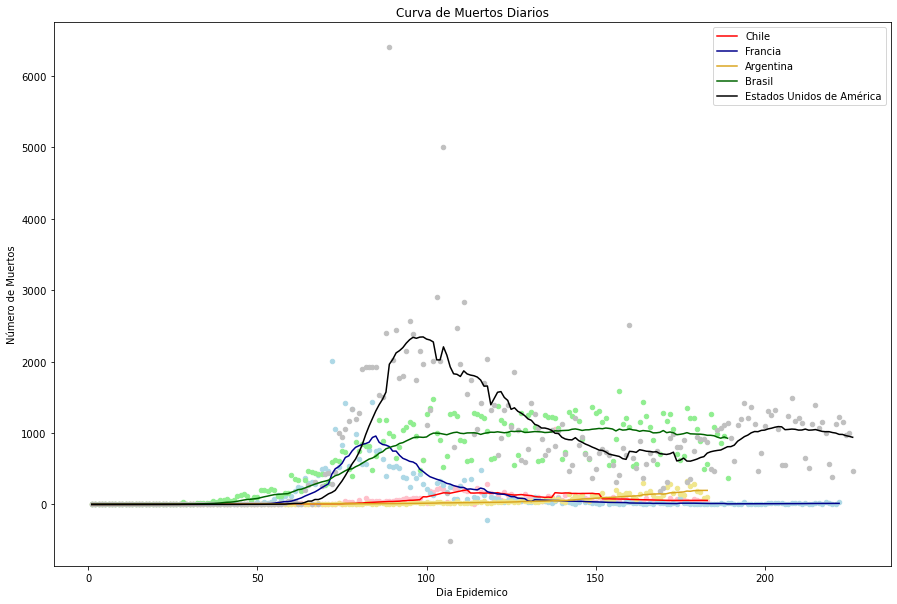

In [248]:
ax=plt.gca()
for x in ctry:
    ctry_name = ctry_data.loc[ctry_data['ISO3166-1-Alpha-2']==x,'official_name_es'].values[0]
    data[(data['Country_code']==x)].plot(figsize=(15,10), kind='line', label=ctry_name, x='Epidemic_day',y='New_deaths_s',ax=ax, color=ctry[x][0])
    data[(data['Country_code']==x)].plot(figsize=(15,10), kind='scatter', x='Epidemic_day',y='New_deaths',ax=ax, color=ctry[x][1],title='Curva de Muertos Diarios')
ax.set_xlabel("Dia Epidemico")
ax.set_ylabel("Número de Muertos")
plt.savefig('Curva-Muertos.png')
plt.show()